In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import heapq
import psycopg2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.gridspec as gridspec

/usr/local/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
query = """ 
    select dq.event_date, c.label, dq.close_value
    from company c
    inner join daily_quote dq on c.id = dq.company_id
    where 1 = 1
    and ibovespa = true
    and (now() - dq.event_date) <= interval '12 months'
    order by dq.event_date, c.label;"""

In [3]:
conn = psycopg2.connect(
            database="postgres",
            user="postgres",
            connect_timeout=3,
            options='-c statement_timeout=3000')
raw_df = pd.read_sql(query, conn)
conn.close()

In [4]:
raw_df.columns = ['Data', 'Sigla', 'Valor_de_Fechamento']
raw_df.set_index(['Data', 'Sigla'], inplace=True)

In [5]:
df = (raw_df.unstack()
          .replace({0: np.NaN})
          .fillna(method='bfill')
          .dropna(axis=1))
df = df.loc[:, 'Valor_de_Fechamento'].copy()

In [6]:
df.head(5)

Sigla,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,BRML3,BTOW3,...,SMLS3,SUZB3,TAEE11,TIMP3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3
Data,,,,,,,,,,,,,,,,,,,,,
2018-03-19,23.79,41.40,33.0273,34.4000,28.05,31.10,25.00,47.53,11.15,26.86,...,71.33,30.60,24.61,14.39,70.98,10.60,41.10,49.77,7.91,17.8538
2018-03-20,23.69,41.56,32.9727,34.3636,28.15,31.55,24.50,47.42,11.20,27.73,...,70.50,30.45,24.61,14.56,70.46,10.95,41.60,49.30,7.66,17.7154
2018-03-21,23.89,42.25,33.2727,34.5364,28.39,32.19,24.28,47.86,11.27,28.00,...,68.40,31.77,24.61,14.29,70.80,11.22,42.50,49.00,7.78,17.8077
2018-03-22,24.01,41.49,33.7727,34.7454,28.65,31.60,24.52,47.21,11.76,27.76,...,68.25,32.50,24.61,14.17,70.02,11.09,41.93,49.05,7.85,17.8461
2018-03-23,23.92,41.20,34.1818,34.9818,29.51,31.15,23.87,46.53,11.58,26.99,...,69.22,33.19,24.61,14.05,69.25,10.95,41.60,48.67,7.84,17.7000


In [7]:
df.describe()

Sigla,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,BRML3,BTOW3,...,SMLS3,SUZB3,TAEE11,TIMP3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,...,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,18.804184,38.171046,30.682377,34.117425,26.667322,31.767448,22.080000,51.418828,11.326109,32.728285,...,50.890084,42.652887,24.611799,12.666987,49.455649,9.284477,51.120460,44.916192,5.939372,17.978529
std,2.354555,8.180665,5.047915,5.595444,1.814743,2.610442,1.593759,4.716521,1.558688,7.589895,...,9.970388,4.940114,0.023792,1.188993,8.572789,1.058857,4.589628,3.649164,1.200469,1.034798
min,15.000000,24.520000,22.700000,24.910000,22.940000,26.200000,17.910000,41.120000,9.000000,23.000000,...,31.700000,30.450000,24.580000,10.630000,36.700000,7.000000,40.860000,37.520000,4.010000,15.210000
25%,17.020000,30.620000,26.000000,29.225000,25.000000,29.900000,20.775000,47.615000,10.000000,26.850000,...,43.725000,38.310000,24.610000,11.835000,42.825000,8.365000,48.325000,41.395000,4.955000,17.315000
50%,18.400000,37.350000,30.580000,33.450000,26.860000,31.600000,22.140000,51.220000,11.180000,29.600000,...,49.120000,43.110000,24.610000,12.290000,48.320000,9.370000,51.450000,45.620000,5.630000,18.130000
75%,19.415000,44.085000,33.790450,37.675000,27.935000,33.670000,23.205000,54.900000,12.795000,37.720000,...,55.675000,46.420000,24.610000,13.205000,54.005000,10.030000,54.300000,47.780000,6.750000,18.750000
max,24.200000,54.810000,41.340000,46.300000,31.620000,38.320000,25.970000,61.660000,14.510000,49.900000,...,75.800000,54.420000,24.960000,15.950000,70.980000,11.450000,62.200000,51.290000,8.640000,19.900000


In [8]:
series = np.sum(df.isna())
series[series > 0]

Series([], dtype: int64)

In [9]:
column_names = df.columns.values
for cn in column_names:
    df[cn] = (df[cn] / df[cn].shift(1) - 1).fillna(0)    

In [10]:
df.head(5)

Sigla,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,BRML3,BTOW3,...,SMLS3,SUZB3,TAEE11,TIMP3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3
Data,,,,,,,,,,,,,,,,,,,,,
2018-03-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-03-20,-0.004203,0.003865,-0.001653,-0.001058,0.003565,0.014469,-0.020000,-0.002314,0.004484,0.032390,...,-0.011636,-0.004902,0.0,0.011814,-0.007326,0.033019,0.012165,-0.009443,-0.031606,-0.007752
2018-03-21,0.008442,0.016603,0.009098,0.005029,0.008526,0.020285,-0.008980,0.009279,0.006250,0.009737,...,-0.029787,0.043350,0.0,-0.018544,0.004825,0.024658,0.021635,-0.006085,0.015666,0.005210
2018-03-22,0.005023,-0.017988,0.015027,0.006052,0.009158,-0.018329,0.009885,-0.013581,0.043478,-0.008571,...,-0.002193,0.022978,0.0,-0.008397,-0.011017,-0.011586,-0.013412,0.001020,0.008997,0.002156
2018-03-23,-0.003748,-0.006990,0.012113,0.006804,0.030017,-0.014241,-0.026509,-0.014404,-0.015306,-0.027738,...,0.014212,0.021231,0.0,-0.008469,-0.010997,-0.012624,-0.007870,-0.007747,-0.001274,-0.008187


In [11]:
np.seterr(invalid='raise')
means = np.mean(df)
covariance_matrix = np.cov(df, rowvar=False)
# covariance_matrix = df.cov().values

In [12]:
def risk_profit(a):
    return np.sqrt(np.dot(np.dot(a, covariance_matrix), a)), np.sum(np.multiply(a, means))

### Função multi-objetivo
A função f tentará minimizar a variancia da carteira e maximizar o seu retorno

In [13]:
def f(x):
    # return 1.0 / np.sum(np.multiply(x, means)) # maximiza o lucro
    # return np.dot(np.dot(x, covariance_matrix), x) # minimiza o risco
    #return (np.dot(x.T, np.dot(covariance_matrix, x))) / np.sum(np.multiply(x, means)) # 2nd version
    #return np.dot(np.dot(x, covariance_matrix), x) / np.sum(np.multiply(x, means))
    # https://en.wikipedia.org/wiki/Modern_portfolio_theory
    q = .8
    return np.dot(x.T, np.dot(covariance_matrix, x)) - q * np.dot(means.T, x)

SLSQP - Sequential Least Squares Programming

SLSQP optimizer is a sequential least squares programming algorithm which uses the Han–Powell quasi–Newton method with a BFGS update of the B–matrix and an L1–test function in the step–length algorithm. The optimizer uses a slightly modified version of Lawson and Hanson’s NNLS nonlinear least-squares solver. [Kraft1988] [LICENSE]

http://www.pyopt.org/reference/optimizers.slsqp.html

In [14]:
cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}]
n = df.shape[1]
x0 = np.random.rand(n) # gera n valores aleatórios
x0 = x0 / np.sum(x0) # padroniza os valores de moro que a soma seja igual a 1.0
result = minimize(f, x0, constraints=cons, method='SLSQP', options={'disp': 'True', 'maxiter': 10000})
# result = minimize(f, x0, method='Powell', options={'disp': 'True', 'maxiter': 100})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.028899322030165854
            Iterations: 48
            Function evaluations: 3121
            Gradient evaluations: 48


### Representação visual da carteira otimizada!

risk=0.1697088444135589, profit=0.07212551737793922


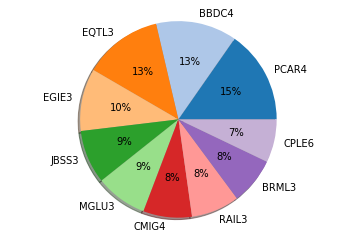

[3.427003171269552, 2.987234195925457, 2.9023372562840097, 2.300955421656627, 1.9698623142044922, 1.9070823502984782, 1.7921010823260701, 1.774730662745597, 1.7338427489733155, 1.5898048705453132]
['PCAR4', 'BBDC4', 'EQTL3', 'EGIE3', 'JBSS3', 'MGLU3', 'CMIG4', 'RAIL3', 'BRML3', 'CPLE6']


In [15]:
from matplotlib import cm
diff_companies = 10
cm = plt.cm.get_cmap('tab20')
optimal_values = []
optimized = result.success
if optimized:
    risk, profit = risk_profit(result.x)
    print("risk=%s, profit=%s" % (risk, profit))
    optimal_values = result.x
    nlargest = heapq.nlargest(diff_companies, enumerate(optimal_values), key=lambda x: x[1])
    nlargest_indexes = [i for (i, j) in nlargest]
    nlargest_values = [j for (i, j) in nlargest]
    labels = [label for label in df.columns[nlargest_indexes].values]
    fig1, ax1 = plt.subplots()
    ax1.pie(nlargest_values, labels=labels, shadow=True, autopct='%1.0f%%', colors=cm.colors)
    ax1.axis('equal')
    plt.show()
    print(nlargest_values)
    print(labels)
else:
    print('FUNCTION COULD NOT BE OPTIMIZED!')

In [16]:
sum_value = np.sum(nlargest_values)
percentages = np.round((nlargest_values / sum_value) * 100)
labeled_percentages = zip(percentages, labels)
print(list(labeled_percentages))
print(labels)

[(15.0, 'PCAR4'), (13.0, 'BBDC4'), (13.0, 'EQTL3'), (10.0, 'EGIE3'), (9.0, 'JBSS3'), (9.0, 'MGLU3'), (8.0, 'CMIG4'), (8.0, 'RAIL3'), (8.0, 'BRML3'), (7.0, 'CPLE6')]
['PCAR4', 'BBDC4', 'EQTL3', 'EGIE3', 'JBSS3', 'MGLU3', 'CMIG4', 'RAIL3', 'BRML3', 'CPLE6']


In [17]:
# [(14.0, 'MPLU3'), (12.0, 'FRAS3'), (11.0, 'ELET6'), (10.0, 'UNIP3'), (10.0, 'ITSA3'), (9.0, 'PETR3'), (9.0, 'BBDC4'), (9.0, 'LREN3'), (8.0, 'BRAP4'), (8.0, 'ECOR3')]
# [(22.0, 'MPLU3'), (12.0, 'UNIP3'), (11.0, 'ELET6'), (10.0, 'ECOR3'), (8.0, 'FLRY3'), (8.0, 'ITSA3'), (8.0, 'LREN3'), (8.0, 'BBDC4'), (7.0, 'FRAS3'), (6.0, 'ITSA4')]

In [18]:
df = (raw_df.unstack()
      .replace({0: np.NaN})
      .fillna(method='ffill'))
df = df.loc[:, 'Valor_de_Fechamento'].copy()
df.tail()

Sigla,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,BRML3,BTOW3,...,SMLS3,SUZB3,TAEE11,TIMP3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3
Data,,,,,,,,,,,,,,,,,,,,,
2019-02-28,17.23,50.60,38.53,43.27,27.30,28.82,20.57,54.40,13.39,48.35,...,48.00,47.66,NaN,11.82,53.41,9.66,47.10,46.79,4.58,18.42
2019-03-01,16.76,51.31,37.40,42.55,26.86,28.66,20.52,55.05,13.11,49.31,...,47.41,48.56,24.61,11.61,51.40,9.70,46.74,46.08,4.54,18.34
2019-03-06,16.37,50.60,37.18,42.21,26.61,29.47,19.70,54.65,12.90,48.47,...,46.31,48.19,24.72,11.46,51.20,9.62,48.05,45.55,4.39,18.58
2019-03-07,16.69,50.43,37.44,42.51,26.49,29.86,19.49,54.50,12.96,48.02,...,46.54,48.63,24.58,11.41,51.90,9.63,48.86,45.80,4.41,18.52
2019-03-08,16.59,52.20,37.80,43.10,26.60,29.80,19.90,54.98,13.24,49.90,...,47.30,47.04,24.96,11.75,52.50,9.67,48.85,46.50,4.68,18.80


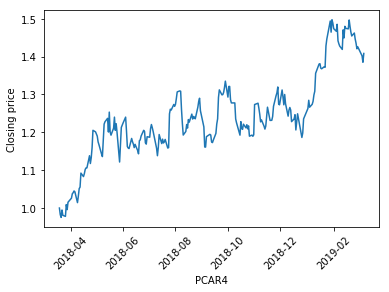

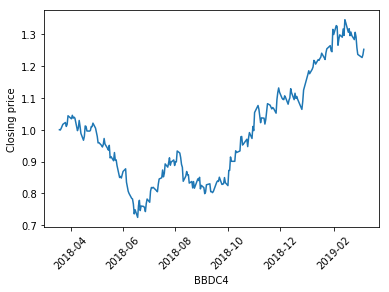

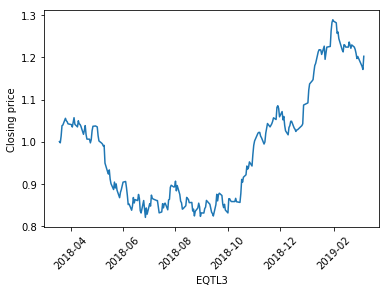

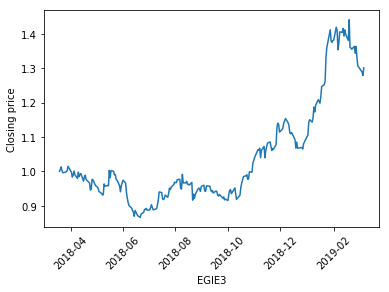

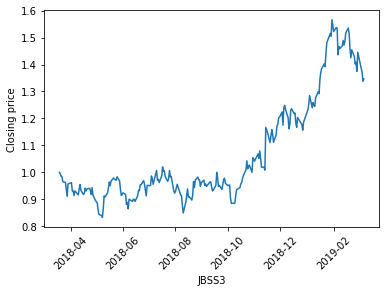

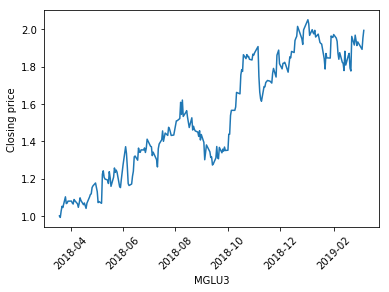

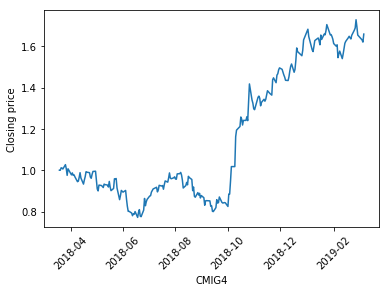

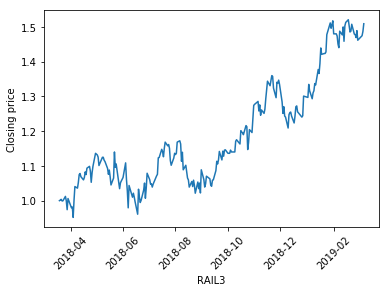

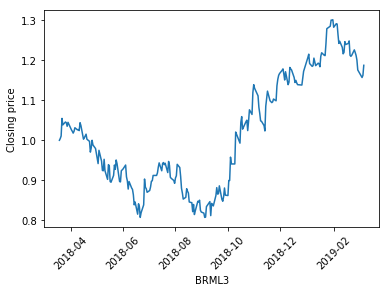

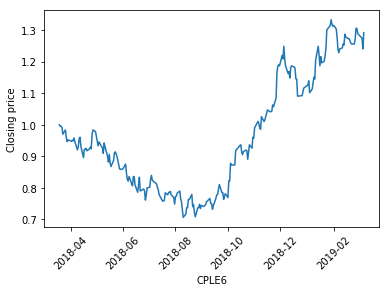

In [19]:
securities = df[labels]
first_row = securities.iloc[0]
ndf = securities / first_row
for label in ndf.columns.values:
    plt.figure()
    company = ndf[label]
    plt.ylabel('Closing price')
    plt.xlabel(company.name)
    plt.xticks(rotation=45)
    #plt.ylim(0, 100)
    plt.plot(ndf.index.values, company)

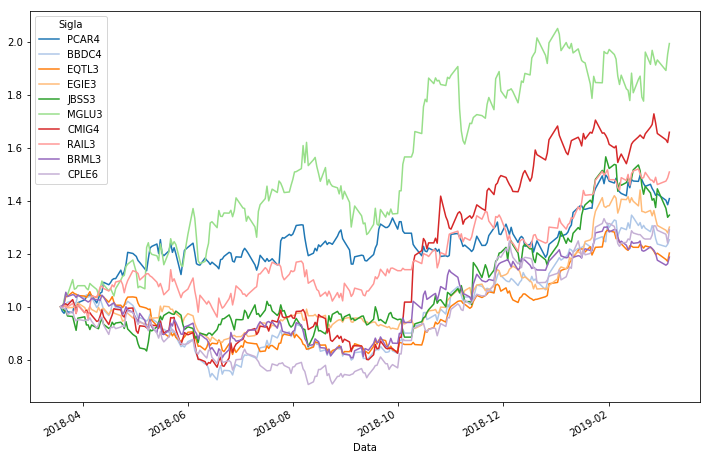

In [20]:
ndf.plot(figsize=(12, 8), color=cm.colors)
plt.show()

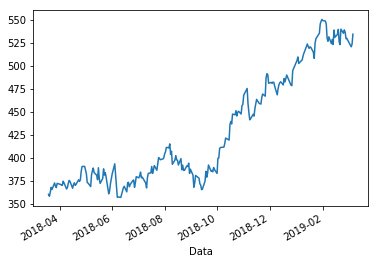

In [21]:

virtual_portfolio = securities.copy()

for (weight, asset) in labeled_percentages:
    virtual_portfolio[asset] = virtual_portfolio[asset] * weight / 100.0

portfolio = np.sum(virtual_portfolio, axis=1)
plt.figure()
portfolio.plot()

# plt.figure()
# new_virtual_portfolio = np.mean(virtual_portfolio, axis=1) * 250
# new_virtual_portfolio.plot()

# Lucro percentual e nominal

In [22]:
initial_value = portfolio.iloc[0]
current_value = portfolio.iloc[-1]
profit = current_value - initial_value
print(initial_value)
print(current_value)
print(profit)
print('Lucro nominal=%s; Lucro percentual=%s' % (profit, profit/initial_value))

359.99999999999994
534.47
174.47000000000008
Lucro nominal=174.47000000000008; Lucro percentual=0.4846388888888892
